## Anomaly detection - Time series
### using clustering method

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>

<div style="text-align: right\"> Initial upload: 2021.1.18 </div>
<div style="text-align: right\"> Last update: 2021.1.18</div>

clustering 방법을 사용하여 EKG 데이터의 이상치를 검출한다.

참고자료  
- https://github.com/mrahtz/sanger-machine-learning-workshop  
- https://nbviewer.jupyter.org/github/mrahtz/sanger-machine-learning-workshop/blob/master/Unsupervised%20Learning.ipynb  
- http://amid.fish/anomaly-detection-with-k-means-clustering

In [1]:
import time
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings; warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [2]:
colors = ["#00798c", "#d1495b", '#edae49', '#66a182', '#4a4a4a',
          '#1a508b', '#e3120b', '#c5a880', '#9F5F80', '#6F9EAF',
          '#0278ae','#F39233', '#A7C5EB', '#54E346', '#ABCE74',
        '#d6b0b1', '#58391c', '#cdd0cb', '#ffb396', '#6930c3']
sns.color_palette(colors[:10])

[(0.0, 0.4745098039215686, 0.5490196078431373),
 (0.8196078431372549, 0.28627450980392155, 0.3568627450980392),
 (0.9294117647058824, 0.6823529411764706, 0.28627450980392155),
 (0.4, 0.6313725490196078, 0.5098039215686274),
 (0.2901960784313726, 0.2901960784313726, 0.2901960784313726),
 (0.10196078431372549, 0.3137254901960784, 0.5450980392156862),
 (0.8901960784313725, 0.07058823529411765, 0.043137254901960784),
 (0.7725490196078432, 0.6588235294117647, 0.5019607843137255),
 (0.6235294117647059, 0.37254901960784315, 0.5019607843137255),
 (0.43529411764705883, 0.6196078431372549, 0.6862745098039216)]

In [3]:
sns.color_palette(colors[10:])

[(0.00784313725490196, 0.47058823529411764, 0.6823529411764706),
 (0.9529411764705882, 0.5725490196078431, 0.2),
 (0.6549019607843137, 0.7725490196078432, 0.9215686274509803),
 (0.32941176470588235, 0.8901960784313725, 0.27450980392156865),
 (0.6705882352941176, 0.807843137254902, 0.4549019607843137),
 (0.8392156862745098, 0.6901960784313725, 0.6941176470588235),
 (0.34509803921568627, 0.2235294117647059, 0.10980392156862745),
 (0.803921568627451, 0.8156862745098039, 0.796078431372549),
 (1.0, 0.7019607843137254, 0.5882352941176471),
 (0.4117647058823529, 0.18823529411764706, 0.7647058823529411)]

### 1. 데이터 읽기

In [4]:
import struct

In [5]:
def read_ekg_data(input_file):
    """
    Read the EKG data from the given file.
    """
    with open(input_file, 'rb') as input_file:
        data_raw = input_file.read()
    n_bytes = len(data_raw)
    n_shorts = n_bytes/2
    # data is stored as 16-bit samples, little-endian
    # '<': little-endian
    # 'h': short
    unpack_string = '<%dh' % n_shorts
    # sklearn seems to throw up if data not in float format
    data_shorts = np.array(struct.unpack(unpack_string, data_raw)).astype(float)
    return data_shorts

In [8]:
os.listdir()

['.git',
 '.ipynb_checkpoints',
 '1. Classification on imbalanced data using tensorflow.ipynb',
 '2.1 NASA acoustics and vibration-PCA.ipynb',
 '2.2 NASA acoustics and vibration-Autoencoder.ipynb',
 '3. Timeseries anomaly detection using an CNN autoencoder.ipynb',
 '4. Extreme rare event classification using autoencoders.ipynb',
 '5. Time series pattern recognition with air quality sensor data',
 '6. Anomaly detection using clustering method.ipynb',
 'a02.dat',
 'Deep learning for anomaly detection(Kwang Myung Yu).pdf',
 'ex1. Credit card fraud detection',
 'README.md']

In [9]:
data = read_ekg_data('a02.dat')

In [10]:
data

array([-4., -4., -5., ...,  0.,  0.,  0.])

In [11]:
data = pd.Series(data)

In [12]:
data

0         -4.0
1         -4.0
2         -5.0
3         -2.0
4         -2.0
          ... 
3181995    0.0
3181996    0.0
3181997    0.0
3181998    0.0
3181999    0.0
Length: 3182000, dtype: float64

In [14]:
data.shape

(3182000,)

데이터 시각화

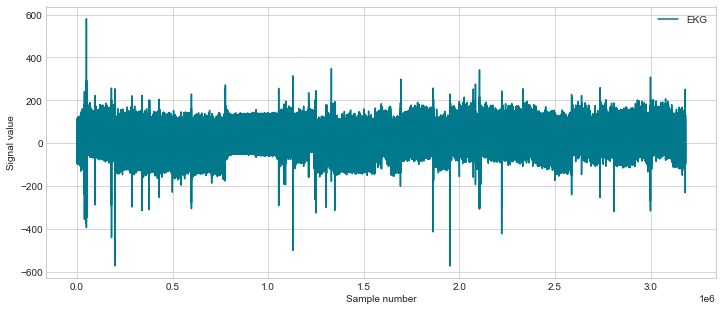

In [16]:
fig, ax = plt.subplots(figsize=(12, 5))
data.plot(ax = ax, color = colors[0], label = 'EKG')
plt.xlabel('Sample number')
plt.ylabel('Signal value')
plt.legend()
plt.show()

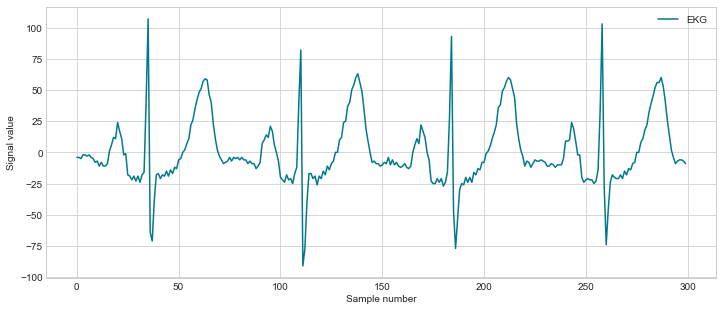

In [17]:
fig, ax = plt.subplots(figsize=(12, 5))
data[:300].plot(ax = ax, color = colors[0], label = 'EKG')
plt.xlabel('Sample number')
plt.ylabel('Signal value')
plt.legend()
plt.show()

데이터 추출하기  
- 데이터 양이 많아서 일부만 추출한다.

In [18]:
data = data[:8192]

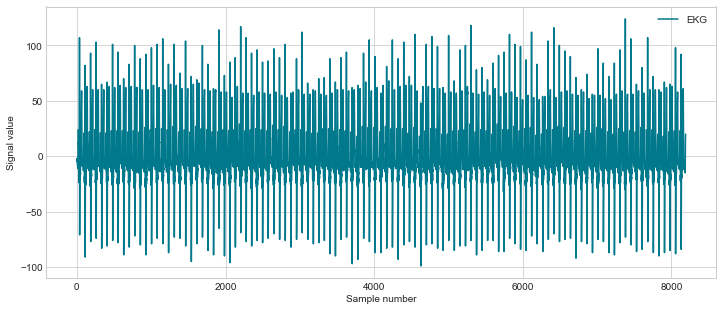

In [19]:
fig, ax = plt.subplots(figsize=(12, 5))
data.plot(ax = ax, color = colors[0], label = 'EKG')
plt.xlabel('Sample number')
plt.ylabel('Signal value')
plt.legend()
plt.show()

### 2. Windowing

시계열 데이터를 중복되는 조각으로 쪼갠다.(overlapping segments)  
윈도우는 2 step 만큼 이동해가며 추출한다.

In [22]:
window_len = 32
slide_len = 2
segments = []

for i in range(0, len(data), slide_len):
    end_pos = i + window_len
    segment = data.values[i : end_pos]
    
    if len(segment) != window_len:
        continue
        
    segments.append(segment)

In [24]:
segments = np.array(segments)

In [25]:
segments.shape

(4081, 32)

In [26]:
segments[0]

array([ -4.,  -4.,  -5.,  -2.,  -2.,  -3.,  -2.,  -4.,  -5.,  -8.,  -7.,
       -11.,  -8., -11., -11.,  -9.,   1.,   6.,  12.,  11.,  24.,  17.,
        11.,  -2.,  -1., -18., -19., -22., -19., -23., -19., -24.])

In [27]:
def plot_waves(waves, step):
    """
    Plot a set of 9 waves from the given set, starting from the first one
    and increasing in index by 'step' for each subsequent graph
    """
    plt.figure()
    n_graph_rows = 3
    n_graph_cols = 3
    graph_n = 1
    wave_n = 0
    for _ in range(n_graph_rows):
        for _ in range(n_graph_cols):
            axes = plt.subplot(n_graph_rows, n_graph_cols, graph_n)
            axes.set_ylim([-100, 150])
            plt.plot(waves[wave_n])
            graph_n += 1
            wave_n += step
    # fix subplot sizes so that everything fits
    plt.tight_layout()
    plt.show()

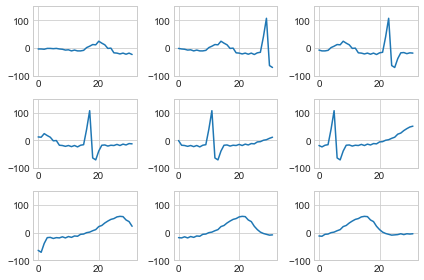

In [28]:
plot_waves(segments, step=3)

- 각 세그먼트 값들이 0에서 시작하지 않는다.  
- 이것은 후에 문제를 발생 시킬수도 있다. (non-zero start, end)  
- 파형을 복원할 때 불연속성을 띄는 문제를 발생한다.

이 불연속성을 해결하기 위해 0으로 시작하고 끝나는 윈도우 함수를 곱한다.

In [29]:
window_rads = np.linspace(0, np.pi, window_len)
window = np.sin(window_rads)**2

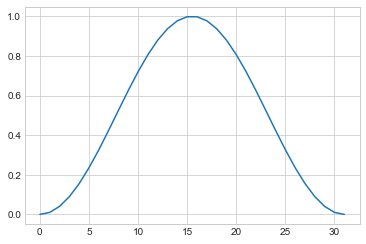

In [30]:
plt.plot(window)
plt.show()

In [31]:
windowed_segments = []
for segment in segments:
    windowed_segment = np.copy(segment) * window
    windowed_segments.append(windowed_segment)

In [33]:
windowed_segments = np.array(windowed_segments)

In [34]:
windowed_segments.shape

(4081, 32)

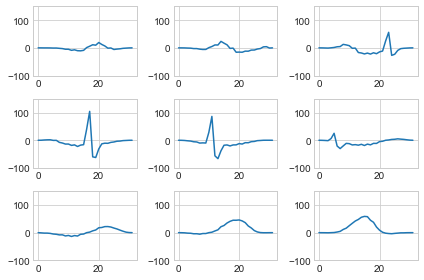

In [35]:
plot_waves(windowed_segments, step=3)

### 3. Clustering

In [36]:
from sklearn.cluster import KMeans

In [37]:
cluster = KMeans(n_clusters=150)
cluster.fit(windowed_segments)

KMeans(n_clusters=150)

클러스터의 centroids를 살펴본다.  

In [38]:
cluster.cluster_centers_

array([[ 0.00000000e+00, -9.04094261e-02,  1.68837892e-01, ...,
        -8.62198837e-01, -1.75701338e-01, -2.99951957e-31],
       [ 0.00000000e+00,  5.40039953e-01,  2.30576282e+00, ...,
        -3.69192192e-01, -3.44010710e-02,  4.68674932e-32],
       [ 0.00000000e+00, -1.57296241e-01, -6.39806750e-01, ...,
        -3.30566821e-01, -8.08028635e-02, -1.00773333e-31],
       ...,
       [ 0.00000000e+00, -1.18585168e-01, -4.77869456e-01, ...,
        -2.73866706e-01, -7.23510697e-02, -8.84341113e-32],
       [ 0.00000000e+00, -1.17702838e-01, -4.45732036e-01, ...,
        -7.96914852e-01, -2.11523940e-01, -3.21198553e-31],
       [ 0.00000000e+00,  5.26710358e-01,  1.67694990e+00, ...,
         3.47026807e-01,  1.33711473e-01,  2.65726669e-31]])

In [39]:
cluster.cluster_centers_.shape

(150, 32)

각 클러스터의 차트를 그려본다.

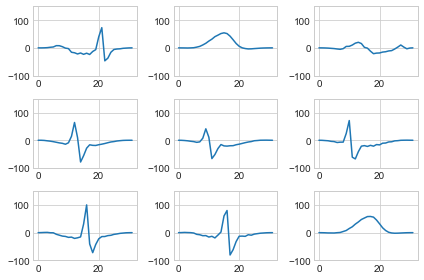

In [40]:
plot_waves(cluster.cluster_centers_, step=15)

- The clusterer appears to have learned a small number of basic shapes, with various horizontal translations.

### 4. Reconstruction from Clusters

복원을하는 방법은 간단하다.  
- 데이터를 overlapping segments로 쪼갠다.  
- 세그먼트와 가장 매칭이 잘되는 클러스터 centroid를 찾는다.  
- 해당 세그먼트 복원을 위해 centroid를 사용한다.  
- 복원된 segment를 join한다.

In [47]:
slide_len = int(window_len/2)

In [48]:
def sliding_chunker(data, window_len, slide_len):
    """
    Split a list into a series of sub-lists, each sub-list window_len long,
    sliding along by slide_len each time. If the list doesn't have enough
    elements for the final sub-list to be window_len long, the remaining data
    will be dropped.
    e.g. sliding_chunker(range(6), window_len=3, slide_len=2)
    gives [ [0, 1, 2], [2, 3, 4] ]
    """
    chunks = []
    for pos in range(0, len(data), slide_len):
        chunk = np.copy(data[pos:pos+window_len])
        if len(chunk) != window_len:
            continue
        chunks.append(chunk)

    return chunks

In [49]:
test_segments = sliding_chunker(data.values, window_len=window_len, 
                                slide_len=slide_len)

In [51]:
test_segments = np.array(test_segments)

In [52]:
test_segments.shape

(511, 32)

In [54]:
centroids = cluster.cluster_centers_

In [55]:
centroids.shape

(150, 32)

In [56]:
segment = test_segments[0]

In [57]:
segment

array([ -4.,  -4.,  -5.,  -2.,  -2.,  -3.,  -2.,  -4.,  -5.,  -8.,  -7.,
       -11.,  -8., -11., -11.,  -9.,   1.,   6.,  12.,  11.,  24.,  17.,
        11.,  -2.,  -1., -18., -19., -22., -19., -23., -19., -24.])

In [63]:
windowed_segment = segment * window

In [64]:
windowed_segment

array([-0.00000000e+00, -4.09401175e-02, -2.02605471e-01, -1.79236559e-01,
       -3.11033081e-01, -7.06553985e-01, -6.52694747e-01, -1.69714444e+00,
       -2.62662292e+00, -5.00261013e+00, -5.04137953e+00, -8.86658290e+00,
       -7.03503249e+00, -1.03089064e+01, -1.07477659e+01, -8.97691196e+00,
        9.97434662e-01,  5.86241777e+00,  1.12460797e+01,  9.67316967e+00,
        1.93452718e+01,  1.22433503e+01,  6.87858893e+00, -1.05064917e+00,
       -4.24286111e-01, -5.87425272e+00, -4.47484190e+00, -3.42136389e+00,
       -1.70274731e+00, -9.31985166e-01, -1.94465558e-01, -3.59942348e-31])

In [71]:
nearest_centroid_idx = cluster.predict(windowed_segment.reshape(1, -1))[0]

In [72]:
nearest_centroid_idx

142

In [73]:
nearest_centroid = np.copy(centroids[nearest_centroid_idx])

In [74]:
nearest_centroid

array([ 0.00000000e+00, -6.94062929e-02, -2.74783670e-01, -5.06903393e-01,
       -8.21321729e-01, -1.17023004e+00, -1.97848095e+00, -2.81089549e+00,
       -3.56235734e+00, -4.82673712e+00, -5.98663819e+00, -7.78344920e+00,
       -8.62890704e+00, -1.02796197e+01, -1.14500347e+01, -1.12211399e+01,
       -2.27539782e+00,  8.82416008e+00,  9.19601309e+00,  1.10746801e+01,
        1.77331658e+01,  1.44714600e+01,  9.10631375e+00,  3.77577045e-01,
       -3.04955642e-01, -4.79322705e+00, -5.09307664e+00, -3.44566335e+00,
       -1.93239415e+00, -9.06659482e-01, -2.23571423e-01, -3.30884502e-31])

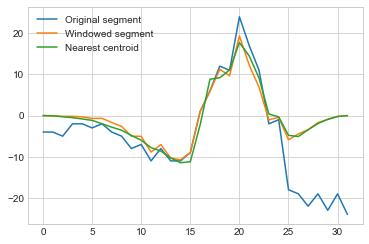

In [75]:
plt.figure()
plt.plot(segment, label="Original segment")
plt.plot(windowed_segment, label="Windowed segment")
plt.plot(nearest_centroid, label="Nearest centroid")
plt.legend()
plt.show()

이제 전체 데이터셋에 대해서 설펴본다.

In [80]:
reconstruction = np.zeros(len(data))
slide_len = int(window_len/2)

for segment_n, segment in enumerate(test_segments):
    # don't modify the data in segments
    segment = np.copy(segment)
    segment *= window
    nearest_centroid_idx = cluster.predict(segment.reshape(1, -1))[0]
    centroids = cluster.cluster_centers_
    nearest_centroid = np.copy(centroids[nearest_centroid_idx])
    
    # overlay our reconstructed segments with an overlap of half a segment
    pos = segment_n * slide_len
    reconstruction[pos:pos+window_len] += nearest_centroid

In [81]:
n_plot_samples = 300

error = reconstruction[0:n_plot_samples] - data[0:n_plot_samples]
error_98th_percentile = np.percentile(error, 98)
print("Maximum reconstruction error was %.1f" % error.max())
print("98th percentile of reconstruction error was %.1f" % error_98th_percentile)

Maximum reconstruction error was 14.7
98th percentile of reconstruction error was 6.8


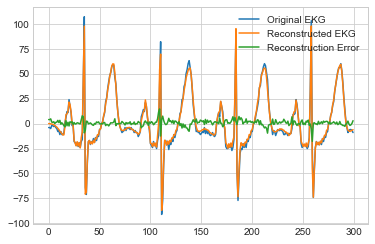

In [82]:
plt.plot(data[0:n_plot_samples], label="Original EKG")
plt.plot(reconstruction[0:n_plot_samples], label="Reconstructed EKG")
plt.plot(error[0:n_plot_samples], label="Reconstruction Error")
plt.legend()
plt.show()

### 5. Anomaly detection

인위적으로 비정상 데이터 부분을 생성해서 검출하는지 시험해본다.

In [83]:
data_anomalous = np.copy(data)
data_anomalous[210:215] = 0

In [87]:
def reconstruct(data, window, clusterer):
    """
    Reconstruct the given data using the cluster centers from the given
    clusterer.
    """
    window_len = len(window)
    slide_len = int(window_len/2)
    segments = sliding_chunker(data, window_len, slide_len)
    reconstructed_data = np.zeros(len(data))
    for segment_n, segment in enumerate(segments):
        # window the segment so that we can find it in our clusters which were
        # formed from windowed data
        segment *= window
        nearest_match_idx = clusterer.predict(segment.reshape(1, -1))[0]
        nearest_match = np.copy(clusterer.cluster_centers_[nearest_match_idx])

        pos = segment_n * slide_len
        reconstructed_data[pos:pos+window_len] += nearest_match

    return reconstructed_data

In [88]:
recontruction = reconstruct(data_anomalous, window, cluster)

In [90]:
reconstruction

array([ 0.00000000e+00, -6.94062929e-02, -2.74783670e-01, ...,
        5.26203505e-01,  1.69238373e-01,  2.76505008e-31])

In [91]:
error = reconstruction[0:n_plot_samples] - data_anomalous[0:n_plot_samples]
error_98th_percentile = np.percentile(error, 98)
print("Maximum reconstruction error was %.1f" % error.max())
print("98th percentile of reconstruction error was %.1f" % error_98th_percentile)

Maximum reconstruction error was 55.6
98th percentile of reconstruction error was 11.6


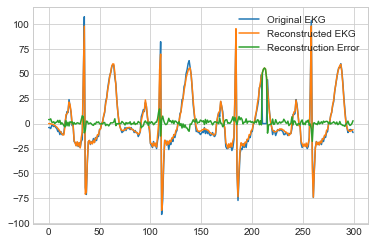

In [93]:
plt.plot(data_anomalous[0:n_plot_samples], label="Original EKG")
plt.plot(reconstruction[0:n_plot_samples], label="Reconstructed EKG")
plt.plot(error[0:n_plot_samples], label="Reconstruction Error")
plt.legend()
plt.show()

Since our anomaly has produced a shape in the waveform that hadn't been seen before, the waveform around that point couldn't be reconstructed using the learned shape library. This gives a large, easily visible reconstruction error! This error could be easily detected using a simple threshold detector.